# Extended Figure 7 - Ye et al. 2023

In [1]:
import matplotlib.pyplot as plt
import glob
import os
import sys
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import ast
plt.rcParams['axes.labelsize'] = 17  # for x and y labels
plt.rcParams['xtick.labelsize'] = 17 # for x axis tick labels
plt.rcParams['ytick.labelsize'] = 17 # for y axis tick labels
plt.rcParams['axes.titlesize'] = 17

In [2]:
rename_dict = {'swimming_ole': 'Kiehn_Lab_Swimming',
           'openfield_ole': 'Kiehn_Lab_Openfield',
           'treadmill_ole': 'Kiehn_Lab_Treadmill',
           'MackenzieMausHaus': 'MausHaus',
           'daniel3mouse': 'TriMice',
           'dlc-openfield': 'DLC_Openfield',
           'TwoWhiteMice_GoldenLab': 'WhiteMice',
           'ChanLab': 'BlackMice'
           }

temp = pd.read_hdf('../data/Figure1/openfield_ratios.h5')


unbalanced_zeroshot = temp.loc['unbalanced_zeroshot', '600000']  # .mean(axis=0)


zeroshot_with_mask = unbalanced_zeroshot['RMSE']




/var/folders/n5/5_x4w2px2wn6hc6n_9zzlygw0000gn/T/ipykernel_86743/2577710120.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  unbalanced_zeroshot = temp.loc['unbalanced_zeroshot', '600000']  # .mean(axis=0)


## Ablation study on SuperAnimap-TopviewMouse, with or without gradient masking

/Users/shaokaiye/miniforge3/envs/mausspaun/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:grey'` for same effect.
  warnings.warn(msg, FutureWarning)


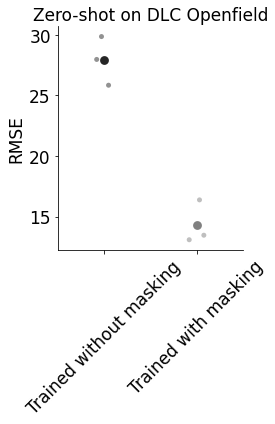

In [3]:
no_mask_zeroshot = pd.read_csv('../data/Extended_Figure7/dlc_openfield_no_masking_zeroshot.csv')
no_mask_zeroshot = no_mask_zeroshot.iloc[:, 1:]
mask_zeroshot = zeroshot_with_mask.to_frame().reset_index()
no_mask_zeroshot['method'] = 'Trained without masking'

mask_zeroshot.columns = ['Shuffle', 'RMSE']
mask_zeroshot['method'] = 'Trained with masking'


df = pd.concat((no_mask_zeroshot, mask_zeroshot),ignore_index=True)


# Create a bar plot
plt.figure(figsize=(4, 6))
#plt.bar(methods, mean_rmse, yerr=std_error, capsize=5, color=['grey', 'grey'])
sns.pointplot(data=df, x="method", y="RMSE", hue='method', color='grey', errorbar=None)
sns.stripplot(data=df, x="method", y="RMSE",  hue='method', color='grey', alpha = .5)

# Adding labels and title

plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title("Zero-shot on DLC Openfield")
plt.xlabel('')
sns.despine()  # Removing top and right spines
plt.tight_layout()
ax = plt.gca()  # Get the current axes instance
ax.get_legend().remove()
# Show the plot
plt.savefig('masking_ablation_study.png', dpi = 300, transparent = True)

## Ablation study. To measure catastrophic forgetting in terms of keypoint-dropping between naive fine-tuning and memory replay

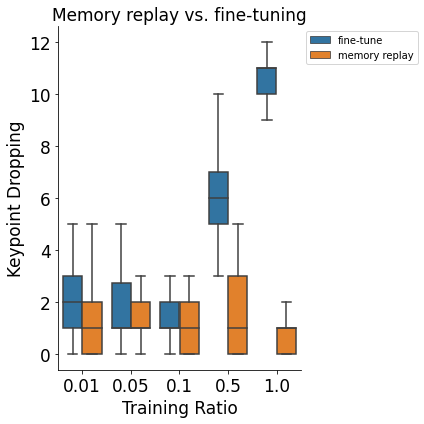

In [7]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('../data/Extended_Figure7/TD_dlc_openfield_memory_replay_ablation_study.csv')

df['method'] = df['method'].replace({'memory-replay' : 'memory replay', 'finetune': 'fine-tune'})

# Filter the data for 'finetune' and 'memory-replay' methods
filtered_data = df


# Expand the 'keypoint_dropping' lists into individual rows
# Assuming 'keypoint_dropping' is a column of lists or similar structure
rows = []
for index, row in filtered_data.iterrows():
    if pd.notna(row['keypoint_dropping']):  # Ensure the value is not NaN
        keypoint_list = ast.literal_eval(row['keypoint_dropping'])

        for keypoint_value in keypoint_list:
            rows.append({
                'method': row['method'],
                'training_ratio': row['training_ratio'],
                'keypoint_dropping': keypoint_value
            })

expanded_data = pd.concat([pd.DataFrame([row]) for row in rows], ignore_index=True)

# Creating the box plot with the expanded data
plt.figure(figsize=(6, 6))
sns.boxplot(x='training_ratio', y='keypoint_dropping', hue='method', data=expanded_data, showfliers = False)
plt.title('Memory replay vs. fine-tuning')
plt.xlabel('Training Ratio')
plt.ylabel('Keypoint Dropping')
plt.legend(title='Method')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
sns.despine()
plt.savefig('memory_replay_ablation.png', transparent = True, dpi = 300)

In [8]:
df = pd.read_csv('../data/Extended_Figure7/permutation_test_keypoint_matching.csv')

df.columns=['dataset', 'shuffle', 'number of permutation', 'NE_OOD', 'mAP']

df['number of permutation'] = df['number of permutation'].str.replace('permutation_', '')


df['mAP']*=100
df = df.round(2)


horse10_df = df[df['dataset'] == 'horse10']
rodent_df = df[df['dataset'] == 'rodent']



## Ablation study: Random permutation in our keypoint matching results in performance drop for zero-shot for Horse-10

/Users/shaokaiye/miniforge3/envs/mausspaun/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:grey'` for same effect.
  warnings.warn(msg, FutureWarning)


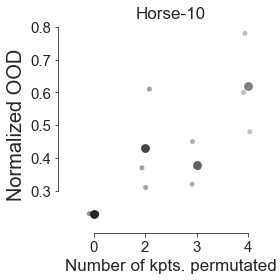

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style("ticks")

df = horse10_df

df.columns = ['dataset', 'shuffle', 'number of permutation', 'NE_OOD', 'mAP']

fig, ax1 = plt.subplots(
    ncols=1,
    tight_layout=True,
    figsize=(4, 4),
    sharex=True,
    sharey=True,
)

pal = 'magma_r'
sns.pointplot(data=df, x="number of permutation", y="NE_OOD", ax=ax1, hue='number of permutation', color='grey', errorbar=None)
sns.stripplot(data=df, x="number of permutation", y="NE_OOD", ax=ax1, hue='number of permutation', color='grey', alpha = .5)

ax1.legend().remove()

ax1.set_xlabel('')


plt.ylabel("Normalized OOD", fontsize=20)

ax1.tick_params(axis="both", which="major", labelsize=15)

sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 10, "left": 10},)
plt.title('Horse-10')
ax1.set_xlabel('Number of kpts. permutated')
plt.savefig('horse10_keypoint_matching_ablation.png', dpi = 300, transparent = True)


## Ablation study: Random permutation in our keypoint matching results in performance drop for zero-shot for iRodent

/Users/shaokaiye/miniforge3/envs/mausspaun/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:grey'` for same effect.
  warnings.warn(msg, FutureWarning)


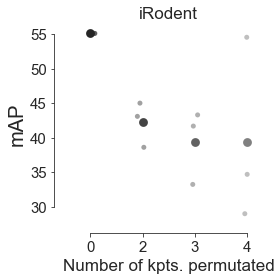

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style("ticks")

df = rodent_df

df.columns = ['dataset', 'shuffle', 'number of permutation', 'NE_OOD', 'mAP']

fig, ax1 = plt.subplots(
    ncols=1,
    tight_layout=True,
    figsize=(4, 4),
    sharex=True,
    sharey=True,
)

pal = 'magma_r'
sns.pointplot(data=df, x="number of permutation", y="mAP", ax=ax1, hue='number of permutation', color='grey', errorbar=None)
sns.stripplot(data=df, x="number of permutation", y="mAP", ax=ax1, hue='number of permutation', color='grey', alpha = .5)

ax1.legend().remove()

ax1.set_xlabel('')


plt.ylabel("mAP", fontsize=20)

ax1.tick_params(axis="both", which="major", labelsize=15)

sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 10, "left": 10},)
plt.title('iRodent')
ax1.set_xlabel('Number of kpts. permutated')
plt.savefig('rodent_keypoint_matching_ablation.png', dpi = 300, transparent = True)
